In [ ]:
!pip3 install numpy
!pip3 install pandas
!pip3 install matplotlib
!pip3 install seaborn
!pip3 install tensorflow
!pip3 install keras
!pip3 install scikit-learn
!pip3 install spotipy

In [ ]:
#Script to obtain data 
from helpers import *
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns

#Libraries to create the multiclass model
from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasClassifier
from keras.utils import np_utils
#Import tensorflow and disable the v2 behavior and eager mode
import tensorflow as tf
tf.compat.v1.disable_eager_execution()
tf.compat.v1.disable_v2_behavior()

#Library to validate the model
from sklearn.model_selection import cross_val_score, KFold, train_test_split
from sklearn.preprocessing import LabelEncoder,MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import confusion_matrix, accuracy_score

In [2]:
#PREXISTING CODE
df = pd.read_csv("data/data_moods.csv")

In [3]:
#PREXISTING CODE
#features = length,danceability,acousticness,energy,instrumentalness,liveness,valence,loudness,speechiness,tempo
col_features = df.columns[6:-3]
X= MinMaxScaler().fit_transform(df[col_features])
X2 = np.array(df[col_features])
Y = df['mood']

In [4]:
#PREXISTING CODE
#Encodethe categories
encoder = LabelEncoder()
encoder.fit(Y)
encoded_y = encoder.transform(Y)


#Convert to  dummy (Not necessary in my case)
dummy_y = np_utils.to_categorical(encoded_y)

X_train,X_test,Y_train,Y_test = train_test_split(X,encoded_y,test_size=0.2,random_state=15)

target = pd.DataFrame({'mood':df['mood'].tolist(),'encode':encoded_y}).drop_duplicates().sort_values(['encode'],ascending=True)
target

,mood,encode
5,Calm,0
4,Energetic,1
0,Happy,2
1,Sad,3


In [5]:
#PREXISTING CODE
def base_model():
    #Create the model
    model = Sequential()
    #Add 1 layer with 8 nodes,input of 10 dim with relu function
    model.add(Dense(8,input_dim=10,activation='relu'))
    #Add 1 layer with output 4 and softmax function
    model.add(Dense(4,activation='softmax'))
    #Compile the model using sigmoid loss function and adam optim
    model.compile(loss='categorical_crossentropy',optimizer='adam',
                 metrics=['accuracy'])
    return model

In [6]:
#PREXISTING CODE
#Configure the model
estimator = KerasClassifier(build_fn=base_model,epochs=300,batch_size=200,verbose=0)

C:\Users\Steven\AppData\Local\Temp\ipykernel_16248\2455418095.py:2: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  estimator = KerasClassifier(build_fn=base_model,epochs=300,batch_size=200,verbose=0)


In [7]:
#PREXISTING CODE
#Evaluate the model using KFold cross validation
kfold = KFold(n_splits=10,shuffle=True)
results = cross_val_score(estimator,X,encoded_y,cv=kfold)
print("Baseline: %.2f%% (%.2f%%)" % (results.mean()*100,results.std()*100))

C:\Users\Steven\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\keras\engine\training_v1.py:2335: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates


Baseline: 77.47% (3.74%)


In [8]:
#PREXISTING CODE
estimator.fit(X_train,Y_train)
y_preds = estimator.predict(X_test)

C:\Users\Steven\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\keras\engine\training_v1.py:2359: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


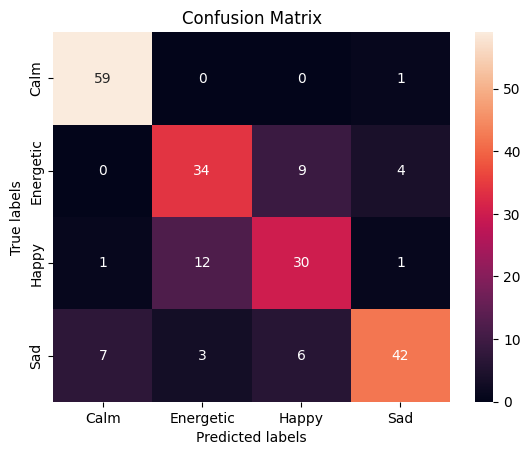

Accuracy Score 0.7894736842105263


In [10]:
#PREXISTING CODE
cm = confusion_matrix(Y_test,y_preds)
ax = plt.subplot()
sns.heatmap(cm,annot=True,ax=ax)

labels = target['mood']
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels')
ax.set_title('Confusion Matrix')
ax.xaxis.set_ticklabels(labels)
ax.yaxis.set_ticklabels(labels)
plt.show()

print("Accuracy Score",accuracy_score(Y_test,y_preds))

In [10]:
#PREXISTING CODE
#Join the model and the scaler in a Pipeline
pip = Pipeline([('minmaxscaler',MinMaxScaler()),('keras',KerasClassifier(build_fn=base_model,epochs=300,
                                                                             batch_size=200,verbose=0))])
#Fit the Pipeline
pip.fit(X2,encoded_y)

C:\Users\Steve\AppData\Local\Temp\ipykernel_47224\3699924158.py:2: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  pip = Pipeline([('minmaxscaler',MinMaxScaler()),('keras',KerasClassifier(build_fn=base_model,epochs=300,


Pipeline(steps=[('minmaxscaler', MinMaxScaler()),
                ('keras',
                 <keras.wrappers.scikit_learn.KerasClassifier object at 0x00000221FFBAB460>)])

In [11]:
#PREXISTING CODE
def predict_mood(id_song):
    #Obtain the features of the song
    preds = get_songs_features(id_song)
    #Pre-process the features to input the Model
    preds_features = np.array(preds[0][6:-2]).reshape(-1,1).T

    #Predict the features of the song
    results = pip.predict(preds_features)

    mood = np.array(target['mood'][target['encode']==int(results)])
    name_song = preds[0][0]
    artist = preds[0][2]

    return print("{0} by {1} is a {2} song".format(name_song,artist,mood[0].upper()))
    #print(f"{name_song} by {artist} is a {mood[0].upper()} song")

In [14]:
#STEVEN MODIFIED PREEXISTING CODE
#returns the mood and the artist name in a tuple
def return_mood(id_song):
    #Obtain the features of the song
    preds = get_songs_features(id_song)
    #Pre-process the features to input the Model
    preds_features = np.array(preds[0][6:-2]).reshape(-1,1).T

    #Predict the features of the song
    results = pip.predict(preds_features)

    mood = np.array(target['mood'][target['encode']==int(results)])
    # name_song = preds[0][0]
    artist = preds[0][2]

    return mood[0].upper(), artist

In [ ]:
#STEVEN: REPRESENTS THE GOAL OF THE PROJECT: TO MAKE A PLAYLIST BASED ON MOOD AND ARTISTS 
#USES A MOOD, ARTIST TUPLE as keys for song dictionary
#takes about 3min for 1000 songs

#playlist to collect songs from
playlist_id = '6HMTU7zp9j3C2o4SXbU7Ll'
#playlist to be added to
myplaylist_id = create_playlist()
#gets ids for first i * 50 songs
ids = get_playlist_track_ids(playlist_id, 20)
#target artists
t_artists = ['the strokes', 'Mac demarco', 'clairo']
clean_artist_names(t_artists)
#target mood
t_mood = "CALM"
#mood and artist tuple form the keys for the dictionary that stores a list of corresponding track ids
song_dict = {}
for i in range(len(ids)):
    print(i)
    id = ids[i]
    mood_artist = return_mood(id)
    if mood_artist in song_dict:
        song_dict[mood_artist].append(id)
    else:
        song_dict[mood_artist] = [id]
for artist in t_artists:
    songs = song_dict.get((t_mood,artist))
    if songs is not None:
        add_to_playlist(myplaylist_id, songs)    


In [ ]:
#STEVEN: Playlist just based off sad mood
#takes close to 20.2 seconds

#playlist to collect songs from
playlist_id = '4GtQVhGjAwcHFz82UKy3Ca'
#playlist to be added to
myplaylist_id = create_playlist()
#gets ids for first i * 50 songs
ids = get_playlist_track_ids(playlist_id, 1)
#mood and artist dictionary to store track ids for each mood and artist
mood_dict = {"SAD":[], "HAPPY":[], "CALM":[], "ENERGETIC":[]}
artist_dict = {}
for i in range(len(ids)):
    print(i)
    id = ids[i]
    mood, artist = return_mood(id)
    mood_dict[mood].append(id)
    if artist in artist_dict:
        artist_dict[artist].append(id)
    else:
         artist_dict[artist] = [id]
add_to_playlist(myplaylist_id, mood_dict["SAD"])

In [ ]:
#STEVEN: Playlist just based off energetic mood

#playlist to collect songs from (rapcaviar id)
playlist_id = '37i9dQZF1DX0XUsuxWHRQd'
#playlist to be added to
myplaylist_id = create_playlist()
#gets ids for first i * 50 songs
ids = get_playlist_track_ids(playlist_id, 2)
#mood and artist dictionary to store track ids for each mood and artist
mood_dict = {"SAD":[], "HAPPY":[], "CALM":[], "ENERGETIC":[]}
artist_dict = {}
for i in range(len(ids)):
    print(i)
    id = ids[i]
    mood, artist = return_mood(id)
    mood_dict[mood].append(id)
    if artist in artist_dict:
        artist_dict[artist].append(id)
    else:
         artist_dict[artist] = [id]
mood_dict["ENERGETIC"]
add_to_playlist(myplaylist_id, mood_dict["ENERGETIC"])

In [ ]:
#STEVEN: testing predictions on rap_caviar playlist

#rapcaviar id
playlist_id = '37i9dQZF1DX0XUsuxWHRQd'
#gets ids for first i * 50 songs
ids = get_playlist_track_ids(playlist_id, 2)
for id in ids:
    predict_mood(id)